# Menganalisa operator telekomunikasi <a id='intro'></a>
* Analis untuk operator telekomunikasi Megaline. Perusahaan tersebut menawarkan kliennya dua paket prabayar, Surf dan Ultimate. Tujuan dari proyek ini Departemen periklanan ingin mengetahui paket prabayar mana yang menghasilkan lebih banyak pendapatan untuk menyesuaikan anggaran iklan.

* Lakukan analisis awal untuk paket-paket prabayar tersebut berdasarkan sampel klien yang berukuran relatif kecil. Anda akan memiliki 500 data klien Megaline: siapa mereka, dari mana mereka, jenis paket apa yang mereka gunakan, serta jumlah panggilan dan pesan yang mereka kirim di tahun 2018. Tugas Anda adalah untuk menganalisis perilaku klien dan menentukan paket prabayar mana yang mendatangkan lebih banyak pendapatan.

**Deskripsi Paket Prabayar**

Catatan: Megaline membulatkan detik ke menit, serta membulatkan megabita ke gigabita. Untuk panggilan, setiap panggilan individual dibulatkan ke atas: bahkan jika panggilan tersebut berlangsung hanya satu detik, ia akan dihitung sebagai satu menit. Untuk lalu lintas web, setiap sesi web tidak dibulatkan ke atas. Akan tetapi, total untuk sebulan dibulatkan ke atas. Jika seorang pengguna menghabiskan 1025 megabita bulan ini, maka ia akan dikenai biaya untuk 2 gigabita.

**Surf**
1. Biaya bulanan: $20

2. 500 menit durasi panggilan per bulan, 50 SMS, dan 15 GB data

3. Setelah melebihi batas paket, akan dikenakan:
    - 1 menit: 3 sen
    - 1 SMS: 3 sen
    - 1 GB data: $10
    
**Ultimate**
1. Biaya bulanan: $70

2. 3000 menit durasi panggilan per bulan, 1000 SMS, dan 30 GB data

3. Setelah melebihi batas paket, akan dikenakan:
    - 1 menit: 1 sen
    - 1 SMS: 1 sen
    - 1 GB data: $7

## Pra-pemrosesan
Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',100)

### 1. Buka file data dan pelajari informasi umumnya

In [2]:
df_calls = pd.read_csv(r'/datasets/megaline_calls.csv')
df_internet = pd.read_csv(r'/datasets/megaline_internet.csv')
df_messages = pd.read_csv(r'/datasets/megaline_messages.csv')
df_plans = pd.read_csv(r'/datasets/megaline_plans.csv')
df_users = pd.read_csv(r'/datasets/megaline_users.csv')

#### 1.1 Tabel `users` (data pengguna):
* `user_id` — ID pengguna
* `first_name` — nama depan pengguna
* `last_name` — nama belakang pengguna
* `age` — usia pengguna (tahun)
* `reg_date` — tanggal mulai berlangganan (dd, mm, yy)
* `churn_date` — tanggal pengguna berhenti menggunakan layanan (jika nilainya hilang atau tidak ada, berarti paket layanan sedang digunakan saat data ini dibuat)
* `city` — kota tempat tinggal pengguna
* `plan` — nama paket telepon

In [3]:
df_users.info()
print(df_users.describe())
df_users.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000


(500, 8)

In [4]:
df_users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [5]:
df_users.duplicated().sum()

0

In [6]:
df_users.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


#### 1.2 Tabel `calls` (data panggilan):
* `id` — ID sesi web unik
* `call_date` — tanggal panggilan
* `duration` — durasi panggilan (dalam menit)
* `user_id` — ID pengguna yang melakukan panggilan

In [7]:
df_calls.info()
df_calls.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


(137735, 4)

In [8]:
df_calls.duplicated().sum()

0

In [9]:
df_calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


#### 1.3 Tabel `messages` (data SMS):
* `id` — ID SMS unik
* `message_date` — tanggal SMS dikirim
* `user_id` — ID pengguna yang mengirim SMS

In [10]:
df_messages.info()
df_messages.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


(76051, 3)

In [11]:
df_messages.head(10)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


#### 1.4 Tabel `internet` (data sesi web):
* `id` — ID sesi web unik
* `mb_used` — volume data yang dihabiskan selama sesi (dalam megabita)
* `session_date` — tanggal sesi web
* `user_id` — ID pengguna

In [12]:
df_internet.info()
df_internet.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


(104825, 4)

In [13]:
df_internet.head(10)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


#### 1.5 Tabel `plans` (data paket telepon):
* `plan_name` — nama paket telepon
* `usd_monthly_fee` — biaya bulanan dalam dolar AS
* `minutes_included` — alokasi menit panggilan bulanan
* `messages_included` — alokasi SMS bulanan
* `mb_per_month_included` — alokasi volume data bulanan (dalam megabita)
* `usd_per_minute` — harga per menit jika telah melebihi batas alokasi paket (misalnya, jika paket memiliki alokasi 100 menit, maka penggunaan mulai dari menit ke-101 akan dikenakan biaya)
* `usd_per_message` — harga per SMS jika telah melebihi batas alokasi paket
* `usd_per_gb` — harga per ekstra gigabita data jika telah melebihi batas alokasi paket (1 GB = 1024 megabita)

In [14]:
df_plans.info()
df_plans.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


(2, 8)

In [15]:
df_plans.head(10)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


**Kesimpulan:**

Setelah dilakukan pengecekan data terdapat beberapa nilai yang hilang dan beberapa tipe data harus disesuaikan dengan kebutuhan
* Nilai yang hilang pada tabel:
`user` [churn_date]
* Data yang perlu disesuaikan tipe datanya dari object menjadi date time pada tabel:
`user` [reg_date], [churn_date],
`calls` [call_date],
`messages` [message_date],
`internet` [session_date]

### 2. Mempersiapkan data
* Konversikan data menjadi tipe data yang dibutuhkan
* Temukan dan eliminasi kesalahan pada data

In [16]:
def to_month(dataset, col_name):
    temp_array = pd.to_datetime(dataset[col_name])
    return temp_array

In [17]:
# Konversi tipe data 'calls_date'
df_calls['call_date'] = to_month(df_calls, 'call_date')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [18]:
# Konversi tipe data 'message_date'
df_messages['message_date'] = to_month(df_messages, 'message_date')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [19]:
# Konversi tipe data 'internet session_date'
df_internet['session_date'] = to_month(df_internet, 'session_date')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [20]:
# Konversi tipe data 'reg_date'
df_users['reg_date'] = to_month(df_users, 'reg_date')
df_users['churn_date'] = to_month(df_users, 'churn_date')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [21]:
# Menghilangkan informasi city yang tidak diperlukan
df_users['city_name'] = df_users['city'].str.split(',').str[1]
df_users['city_name'] = df_users['city_name'].str.replace('MSA','')
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,city_name
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,WA


#### 2.1 Jumlah panggilan yang dilakukan dan menit yang digunakan per bulan

In [22]:
def to_month(dataset, col_name):
    temp_array = pd.to_datetime(dataset[col_name])
    temp_array = temp_array.dt.to_period("M")
    return temp_array

In [23]:
df_calls['month'] = to_month(df_calls, 'call_date')

In [24]:
# Pembulatan panggilan telepon
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,2018-12
1,1000_145,1000,2018-12-27,14.0,2018-12
2,1000_247,1000,2018-12-27,15.0,2018-12
3,1000_309,1000,2018-12-28,6.0,2018-12
4,1000_380,1000,2018-12-30,5.0,2018-12


In [25]:
# Jumlah panggilan yang dilakukan dan menit yang digunakan per bulan
df_calls_agg = pd.pivot_table(df_calls,index=['user_id','month'],values='duration', aggfunc='sum').reset_index()
df_calls_agg

,user_id,month,duration
0,1000,2018-12,124.0
1,1001,2018-08,182.0
2,1001,2018-09,315.0
3,1001,2018-10,393.0
4,1001,2018-11,426.0
...,...,...,...
2253,1498,2018-12,339.0
2254,1499,2018-09,346.0
2255,1499,2018-10,385.0
2256,1499,2018-11,308.0


#### 2.2 Jumlah SMS yang dikirim per bulan

In [26]:
df_messages['month'] = to_month(df_messages, 'message_date')

In [27]:
# Jumlah SMS yang dikirim per bulan
df_messages_agg = pd.pivot_table(df_messages,index=['user_id','month'],values='id', aggfunc='count').reset_index()
df_messages_agg.columns=['user_id','month','sms_count']
df_messages_agg

,user_id,month,sms_count
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36
...,...,...,...
1801,1496,2018-09,21
1802,1496,2018-10,18
1803,1496,2018-11,13
1804,1496,2018-12,11


#### 2.3 Volume data per bulan

In [28]:
df_internet['month'] = to_month(df_internet, 'session_date')

In [29]:
# Jumlah volume internet per bulan
df_internet_agg = pd.pivot_table(df_internet,index=['user_id','month'],values='mb_used', aggfunc='sum').reset_index()
df_internet_agg.head()

,user_id,month,mb_used
0,1000,2018-12,1901.47
1,1001,2018-08,6919.15
2,1001,2018-09,13314.82
3,1001,2018-10,22330.49
4,1001,2018-11,18504.30


In [30]:
# Pembulatan penggunaan internet
df_internet_agg['gb_used'] = np.ceil(df_internet_agg['mb_used'] / 1024)
df_internet_agg

,user_id,month,mb_used,gb_used
0,1000,2018-12,1901.47,2.0
1,1001,2018-08,6919.15,7.0
2,1001,2018-09,13314.82,14.0
3,1001,2018-10,22330.49,22.0
4,1001,2018-11,18504.30,19.0
...,...,...,...,...
2272,1498,2018-12,23137.69,23.0
2273,1499,2018-09,12984.76,13.0
2274,1499,2018-10,19492.43,20.0
2275,1499,2018-11,16813.83,17.0


#### 2.4 Pendapatan bulanan dari setiap pengguna (kurangi batas paket gratis dari jumlah total panggilan, SMS, dan data; kalikan hasilnya dengan nilai paket telepon; tambahkan biaya bulanan tergantung pada paket teleponnya)

In [31]:
df_calls_agg.shape, df_internet_agg.shape

((2258, 3), (2277, 4))

In [32]:
# Menggabungkan file call dan internet
df_merge = pd.merge(df_calls_agg, df_internet_agg, on=['user_id','month'], how='outer') 
df_merge

,user_id,month,duration,mb_used,gb_used
0,1000,2018-12,124.0,1901.47,2.0
1,1001,2018-08,182.0,6919.15,7.0
2,1001,2018-09,315.0,13314.82,14.0
3,1001,2018-10,393.0,22330.49,22.0
4,1001,2018-11,426.0,18504.30,19.0
...,...,...,...,...,...
2287,1311,2018-06,NaN,1498.83,2.0
2288,1349,2018-10,NaN,13093.55,13.0
2289,1349,2018-11,NaN,17128.26,17.0
2290,1349,2018-12,NaN,13039.91,13.0


In [33]:
# Menggabungkan gabungan file call & internet dengan file messages
df_merge = pd.merge(df_merge, df_messages_agg, on=['user_id','month'], how='outer') 
df_merge

,user_id,month,duration,mb_used,gb_used,sms_count
0,1000,2018-12,124.0,1901.47,2.0,11.0
1,1001,2018-08,182.0,6919.15,7.0,30.0
2,1001,2018-09,315.0,13314.82,14.0,44.0
3,1001,2018-10,393.0,22330.49,22.0,53.0
4,1001,2018-11,426.0,18504.30,19.0,36.0
...,...,...,...,...,...,...
2288,1349,2018-10,NaN,13093.55,13.0,76.0
2289,1349,2018-11,NaN,17128.26,17.0,72.0
2290,1349,2018-12,NaN,13039.91,13.0,61.0
2291,1361,2018-05,NaN,1519.69,2.0,2.0


In [34]:
df_merge.isna().sum()

user_id        0
month          0
duration      35
mb_used       16
gb_used       16
sms_count    487
dtype: int64

In [35]:
df_merge = df_merge.fillna(0).drop(columns=['mb_used'])
df_merge.head()

,user_id,month,duration,gb_used,sms_count
0,1000,2018-12,124.0,2.0,11.0
1,1001,2018-08,182.0,7.0,30.0
2,1001,2018-09,315.0,14.0,44.0
3,1001,2018-10,393.0,22.0,53.0
4,1001,2018-11,426.0,19.0,36.0


In [36]:
df_users_merge = pd.merge(df_users, df_plans, left_on='plan', right_on='plan_name')

In [37]:
# konvesi ke GB, jika ada kelebihan dibulatkan ke atas
df_users_merge['gb_per_month_included'] = np.ceil(df_users_merge['mb_per_month_included']/1024)

In [38]:
df_merge_full = pd.merge(df_merge, df_users_merge, on=['user_id'])
df_merge_full.head()

,user_id,month,duration,gb_used,sms_count,first_name,last_name,age,city,reg_date,...,city_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,1000,2018-12,124.0,2.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,...,GA,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0
1,1001,2018-08,182.0,7.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,WA,50,15360,500,20,10,0.03,0.03,surf,15.0
2,1001,2018-09,315.0,14.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,WA,50,15360,500,20,10,0.03,0.03,surf,15.0
3,1001,2018-10,393.0,22.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,WA,50,15360,500,20,10,0.03,0.03,surf,15.0
4,1001,2018-11,426.0,19.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,WA,50,15360,500,20,10,0.03,0.03,surf,15.0


In [39]:
# Menghilangkan kolom yang tidak diperlukan
drop_cols = ['first_name','last_name','city','plan_name','mb_per_month_included']
df_merge_full.drop(drop_cols, axis=1, inplace=True)
df_merge_full.tail()

,user_id,month,duration,gb_used,sms_count,age,reg_date,plan,churn_date,city_name,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
2288,1204,2018-11,0.0,21.0,42.0,44,2018-08-20,ultimate,NaT,IL-IN-WI,1000,3000,70,7,0.01,0.01,30.0
2289,1204,2018-12,0.0,36.0,78.0,44,2018-08-20,ultimate,NaT,IL-IN-WI,1000,3000,70,7,0.01,0.01,30.0
2290,1349,2018-10,0.0,13.0,76.0,69,2018-10-01,surf,NaT,MA-NH,50,500,20,10,0.03,0.03,15.0
2291,1349,2018-11,0.0,17.0,72.0,69,2018-10-01,surf,NaT,MA-NH,50,500,20,10,0.03,0.03,15.0
2292,1349,2018-12,0.0,13.0,61.0,69,2018-10-01,surf,NaT,MA-NH,50,500,20,10,0.03,0.03,15.0


In [40]:
df_merge.shape, df_merge_full.shape

((2293, 5), (2293, 17))

In [41]:
def chargeable_calls(row):
    plan = row['plan']
    minutes_used = row['duration']
    
    if plan == 'surf':
        if minutes_used > 500:
            chargeable = (minutes_used - 500) * 0.03
        else:
            chargeable = 0
    if plan == 'ultimate':
        if minutes_used > 3000:
            chargeable = (minutes_used - 3000) * 0.01
        else:
            chargeable = 0
    return chargeable

In [42]:
def chargeable_messages(row):
    plan = row['plan']
    number_of_texts = row['sms_count']
    
    if plan == 'surf':
        if number_of_texts > 50:
            chargeable = (number_of_texts - 50) * 0.03
        else:
            chargeable = 0
    if plan == 'ultimate':
        if number_of_texts > 1000:
            chargeable = (number_of_texts - 1000) * 0.01
        else:
            chargeable = 0
    return chargeable

In [43]:
def chargeable_data(row):
    plan = row['plan']
    data_rounded_up = row['gb_used']
    
    if plan == 'surf':
        if data_rounded_up > 15:
            chargeable = (data_rounded_up - 15) * 10
        else:
            chargeable = 0
    if plan == 'ultimate':
        if data_rounded_up > 30:
            chargeable = (data_rounded_up - 30) * 7
        else:
            chargeable = 0
    return chargeable

In [44]:
df_merge_full['call_charge'] = df_merge_full.apply(chargeable_calls, axis=1)
df_merge_full['message_charge'] = df_merge_full.apply(chargeable_messages, axis=1)
df_merge_full['internet_charge'] = df_merge_full.apply(chargeable_data, axis=1)

In [45]:
# Keuntungan pendapatan setiap bulan dari masing-masing pengguna
df_merge_full['revenue'] = df_merge_full['call_charge'] + df_merge_full['message_charge'] + \
                           df_merge_full['internet_charge'] + df_merge_full['usd_monthly_pay']
df_merge_full.head()

,user_id,month,duration,gb_used,sms_count,age,reg_date,plan,churn_date,city_name,...,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,call_charge,message_charge,internet_charge,revenue
0,1000,2018-12,124.0,2.0,11.0,45,2018-12-24,ultimate,NaT,GA,...,3000,70,7,0.01,0.01,30.0,0.0,0.00,0.0,70.00
1,1001,2018-08,182.0,7.0,30.0,28,2018-08-13,surf,NaT,WA,...,500,20,10,0.03,0.03,15.0,0.0,0.00,0.0,20.00
2,1001,2018-09,315.0,14.0,44.0,28,2018-08-13,surf,NaT,WA,...,500,20,10,0.03,0.03,15.0,0.0,0.00,0.0,20.00
3,1001,2018-10,393.0,22.0,53.0,28,2018-08-13,surf,NaT,WA,...,500,20,10,0.03,0.03,15.0,0.0,0.09,70.0,90.09
4,1001,2018-11,426.0,19.0,36.0,28,2018-08-13,surf,NaT,WA,...,500,20,10,0.03,0.03,15.0,0.0,0.00,40.0,60.00


In [46]:
# Jumlah pengguna ekstra durasi telepon
df_merge_full.loc[df_merge_full.call_charge > 0].groupby(['plan']).count()['user_id']

plan
surf    566
Name: user_id, dtype: int64

In [47]:
# Persentase pengguna ekstra durasi telepon
df_merge_full.loc[df_merge_full.call_charge > 0].groupby(['plan']).count()['user_id']/df_merge_full.groupby(['plan']).count()['user_id'] * 100

plan
surf        35.9822
ultimate        NaN
Name: user_id, dtype: float64

In [48]:
# Spending pengguna ekstra durasi telepon
df_merge_full.loc[df_merge_full.call_charge > 0].groupby(['plan']).mean()['call_charge']

plan
surf    5.124117
Name: call_charge, dtype: float64

In [49]:
# Jumlah pengguna ekstra sms
df_merge_full.loc[df_merge_full.message_charge > 0].groupby(['plan']).count()['user_id']

plan
surf    340
Name: user_id, dtype: int64

In [50]:
# Persentase pengguna ekstra sms
df_merge_full.loc[df_merge_full.message_charge > 0].groupby(['plan']).count()['user_id']/df_merge_full.groupby(['plan']).count()['user_id'] * 100

plan
surf        21.614749
ultimate          NaN
Name: user_id, dtype: float64

In [51]:
# Spending pengguna ekstra sms
df_merge_full.loc[df_merge_full.message_charge > 0].groupby(['plan']).mean()['message_charge']

plan
surf    0.973324
Name: message_charge, dtype: float64

In [52]:
# Jumlah pengguna ekstra internet
df_merge_full.loc[df_merge_full.internet_charge > 0].groupby(['plan']).count()['user_id']

plan
surf        911
ultimate     41
Name: user_id, dtype: int64

In [53]:
# Persentase pengguna ekstra internet 
df_merge_full.loc[df_merge_full.internet_charge > 0].groupby(['plan']).count()['user_id']/df_merge_full.groupby(['plan']).count()['user_id'] * 100

plan
surf        57.914812
ultimate     5.694444
Name: user_id, dtype: float64

In [54]:
# Spending pengguna ekstra internet
df_merge_full.loc[df_merge_full.internet_charge > 0].groupby(['plan']).mean()['internet_charge']

plan
surf        66.739846
ultimate    40.634146
Name: internet_charge, dtype: float64

**Kesimpulan:**

Mengkonversi tipe data, menghilangkan informasi yang tidak diperlukan serta melakukan pembulatan dan menjumlahkan nilai setiap penggunaan telepon,  sms, internet. Setelah itu menggabungkan semua file (durasi telepon,sms,internet) terdapat missing value pada kolom duration, gb_used, sms_count dan dilakukan penanganannya dengan fillna(0). Kemudian melakukan penghitungan keuntungan pendapatan setiap bulan dari masing-masing pengguna.

Mengecek berapa pengguna yang membayar ekstra biaya dari setiap fasilitas:
* Durasi telepon, Pengguna plan surf yang melebihi batas penggunaan telepon sebanyak 36% atau 566 orang, sedangkan pengguna plan ultimate yang melebihi batas penggunaan telepon tidak ada. rata-rata spending ekstra durasi telepon di plan surf sebanyak USD 5.12, sedangkan plan ultimate sebanyak USD 0.
* SMS, Pengguna plan surf yang melebihi batas penggunaan SMS sebanyak 21% atau 340 orang, sedangkan pengguna plan ultimate yang melebihi batas penggunaan SMS tidak ada. rata-rata spending ekstra SMS di plan surf sebanyak USD 0.97, sedangkan plan ultimate sebanyak USD 0.
* Internet, Pengguna plan surf yang melebihi batas penggunaan internet sebanyak 58% atau 911 orang, sedangkan pengguna plan ultimate yang melebihi batas penggunaan internet sebanyak 5.6% atau 41 orang. rata-rata spending ekstra internet di plan surf sebanyak USD 66.7, sedangkan plan ultimate sebanyak USD 40.6.

Meskipun harga paket plan surf hanya USD 20 tapi sebagian usernya bayar ekstra hingga USD 66.7, ini setara dengan bayar lebih mahal dari pada pengguna plan ultimate. Sedangkan di plan ultimate hanya beberapa orang saja yang bayar ekstra, walau rata-rata spending ekstranya tidak lebih besar dari rata-rata ekstra spending di plan surf.


### 3 Analisis datanya

In [55]:
df_merge_full_surf = df_merge_full[df_merge_full['plan']=='surf'].reset_index(drop=True)
df_merge_full_ultimate = df_merge_full[df_merge_full['plan']=='ultimate'].reset_index(drop=True)

In [56]:
def visualize_column(column_name):
    plt.figure(figsize=(7,4))
    plt.subplot()
    plt.title(column_name + ' distribution')
    sns.histplot(df_merge_full_surf[column_name])
    plt.show()

In [57]:
def visualize_column1(column_name):
    plt.figure(figsize=(7,4))
    plt.subplot()
    plt.title(column_name + ' distribution')
    sns.histplot(df_merge_full_ultimate[column_name])
    plt.show()

#### 3.1 Paket Surf

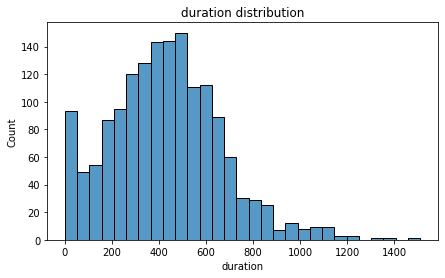

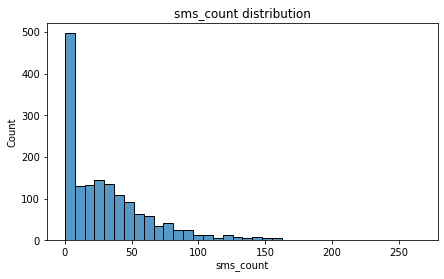

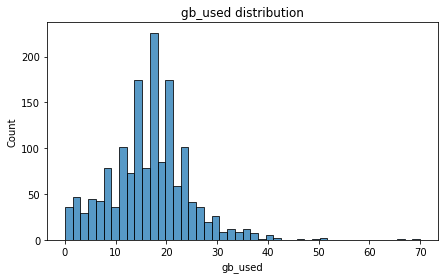

In [58]:
# Distribusi paket 'surf'
columns = ['duration','sms_count','gb_used']
for column in columns:
    visualize_column(column)

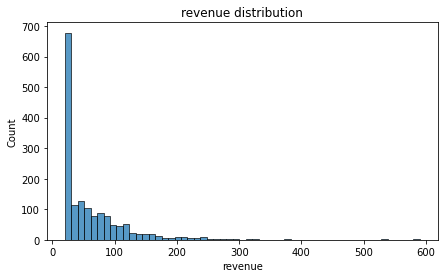

In [59]:
# Pendapatan bulanan dari setiap pengguna paket 'surf'
columns = ['revenue']
for column in columns:
    visualize_column(column)

In [60]:
# Rata-rata dan standar deviasi paket 'surf'
df_merge_full_surf['duration'].describe()

count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: duration, dtype: float64

In [61]:
df_merge_full_surf['sms_count'].describe()

count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: sms_count, dtype: float64

In [62]:
df_merge_full_surf['gb_used'].describe()

count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_used, dtype: float64

In [63]:
# Variasi paket 'surf'
np.var(df_merge_full_surf['duration'])

54933.334591317485

In [64]:
np.var(df_merge_full_surf['sms_count'])

1126.008231726662

In [65]:
np.var(df_merge_full_surf['gb_used'])

61.54444942447023

Jumlah rata-rata penggunaan yang dibutuhkan pengguna paket 'surf' perbulannya adalah:
* Durasi telepon: 428.749523
* SMS: 31.159568
* Volume Data: 16.670693

#### 3.2 Paket Ultimate

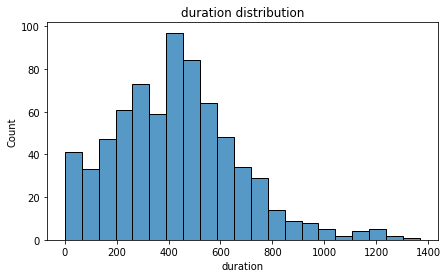

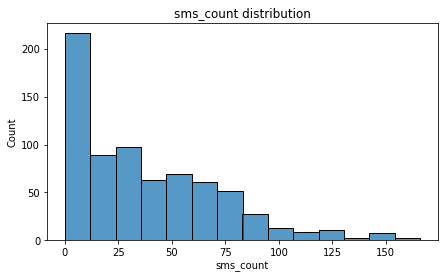

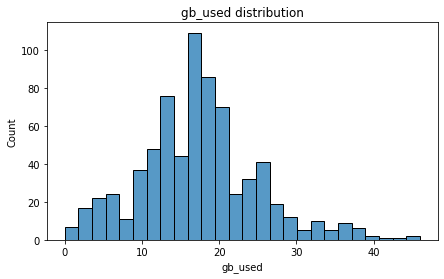

In [66]:
# Distribusi paket 'ultimate'
columns = ['duration','sms_count','gb_used']
for column in columns:
    visualize_column1(column)

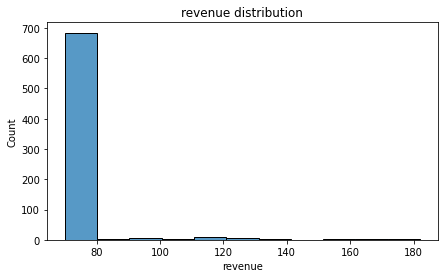

In [67]:
# Pendapatan bulanan dari setiap pengguna paket 'ultimate'
columns = ['revenue']
for column in columns:
    visualize_column1(column)

In [68]:
# Rata-rata dan standar deviasi paket 'ultimate'
df_merge_full_ultimate['duration'].describe()

count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: duration, dtype: float64

In [69]:
df_merge_full_ultimate['sms_count'].describe()

count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: sms_count, dtype: float64

In [70]:
df_merge_full_ultimate['gb_used'].describe()

count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: gb_used, dtype: float64

In [71]:
# Variasi paket 'ultimate'
np.var(df_merge_full_ultimate['duration'])

57764.125277777785

In [72]:
np.var(df_merge_full_ultimate['sms_count'])

1207.0779147376543

In [73]:
np.var(df_merge_full_ultimate['gb_used'])

58.748840663580246

Jumlah rata-rata penggunaan yang dibutuhkan pengguna paket 'ultimate' perbulannya adalah:
* Durasi telepon: 430.450000
* SMS: 37.551389
* Volume Data: 17.306944

In [74]:
# Menghitung rata-rata, varians, dan standar deviasi dari durasi, volume data, sms setiap plan
pd.pivot_table(df_merge_full, index='plan', values=['duration','sms_count','gb_used'], aggfunc=['mean', np.var, np.std])

mean                                 var            \
            duration    gb_used  sms_count      duration   gb_used   
plan                                                                 
surf      428.749523  16.670693  31.159568  54968.279461  61.58360   
ultimate  430.450000  17.306944  37.551389  57844.464812  58.83055   

                              std                       
            sms_count    duration   gb_used  sms_count  
plan                                                    
surf      1126.724522  234.453150  7.847522  33.566717  
ultimate  1208.756744  240.508762  7.670108  34.767179

**Kesimpulan sementara**

Dilihat dari penghitungan rata-rata penggunaan fasilitas yang dibutuhkan oleh pengguna paket surf dan ultimate dalam perbulan tidak terlalu jauh berbeda signifikan pada durasi telepon dan internet, hanya penggunaan SMS yang cukup berbeda diantara keduanya yaitu 31 dan 37.5. Dan mediannya tidak terlalu jauh.

Pengguna paket ultimate lebih banyak menggunakan semua fasilitas telepon, sms, internet dibandingkan dengan paket surf.

Dilihat dari grafik kedua paket penggunaan sms dari keduanya kurang populer dibandingkan penggunaan durasi telepon dan internet, dikarenakan sms sudah tersaingi oleh media messenger lainnya yang lebih kekinian dan hemat biaya.
  

### 4 Uji Hipotesis
#### 4.1 Rata-rata pendapatan dari pengguna paket telepon Ultimate dan Surf berbeda.
 * H0 (Null Hypothesis) = Rata-rata pendapatan dari pengguna paket telepon Ultimate dan Surf adalah sama.
 * H1 (Alternative Hypothesis) = Rata-rata pendapatan dari pengguna paket telepon Ultimate dan Surf adalah tidak sama.

In [75]:
df_merge_full_surf.shape, df_merge_full_ultimate.shape

((1573, 21), (720, 21))

In [76]:
var_surf = np.var(df_merge_full_surf['duration'])
var_ultimate = np.var(df_merge_full_ultimate['duration'])

In [77]:
var_surf, var_ultimate

(54933.334591317485, 57764.125277777785)

In [78]:
np.abs(var_surf-var_ultimate) / var_surf * 100

5.15313826753878

In [79]:
alpha=0.05

results = st.ttest_ind(df_merge_full_surf['duration'], df_merge_full_ultimate['duration'], equal_var=True)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('H1 Accepted / H0 Rejected')
else:
    print('H0 Accepted / H1 Rejected')

p-value:  0.8729861616354788
H0 Accepted / H1 Rejected


**Kesimpulan:**

Setelah dilakukan uji hipotesis rata-rata pendapatan dari pengguna paket telepon Ultimate adalah sama/hampir serupa dengan rata-rata pendapatan dari pengguna paket telepon Surf, bisa dilihat pada varian antara kedua paket yaitu plan ultimate: 57764.125277777785, plan surf: 54933.334591317485 tidak terlalu jauh berbeda. Pengujian statistik kemudian dilakukan dan menghasilkan p-valuenya: 0.87, sehingga hipotesis 0 yang diterima dan menolak hipotesis alternatif.

#### 4.2 Rata-rata pendapatan dari pengguna di wilayah NY-NJ berbeda dengan pendapatan pengguna dari wilayah lain.
 * H0 (Null Hypothesis) = Rata-rata pendapatan dari pengguna di wilayah NY-NJ dengan pendapatan pengguna dari wilayah lain adalah sama.
 * H1 (Alternative Hypothesis) = Rata-rata pendapatan dari pengguna di wilayah NY-NJ dengan pendapatan pengguna dari wilayah lain adalah tidak sama.

In [80]:
df_merge_full_ny = df_merge_full[df_merge_full['city_name']==' NY-NJ-PA '].reset_index(drop=True)
df_merge_full_non_ny = df_merge_full[df_merge_full['city_name']!=' NY-NJ-PA '].reset_index(drop=True)

In [81]:
df_merge_full_ny.shape, df_merge_full_non_ny.shape

((377, 21), (1916, 21))

In [82]:
var_ny = np.var(df_merge_full_ny['user_id'])
var_non_ny = np.var(df_merge_full_non_ny['user_id'])

In [83]:
var_ny, var_non_ny

(20146.095926939615, 20237.089947688077)

In [84]:
np.abs(var_ny-var_non_ny) / var_ny * 100

0.4516707409636779

In [85]:
alpha=0.05

results = st.ttest_ind(df_merge_full_ny['user_id'], df_merge_full_non_ny['user_id'], equal_var=True)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print('H1 Accepted / H0 Rejected')
else:
    print('H0 Accepted / H1 Rejected')

p-value:  3.0497687624201004e-07
H1 Accepted / H0 Rejected


**Kesimpulan:**

Setelah dilakukan uji hipotesis rata-rata pendapatan dari pengguna di wilayah NY-NJ adalah tidak sama dengan rata-rata pendapatan pengguna dari wilayah lain selain NY-NJ, bisa dilihat pada varian antara kedua wilayah NY-NJ: 20146.095926939615, wilayah selain NY-NJ: 20237.089947688077 tidak terlalu jauh berbeda, tetapi wilayah selain NY-NJ merupakan akumulasi dari beberapa wilayah. Pengujian statistik kemudian dilakukan dan menghasilkan p-valuenya: 3.04, sehingga hipotesis alternatif yang diterima dan menolak hipotesis 0 nya.

### 5 Kesimpulan Akhir

Setelah dilakukan pengecekan data terdapat beberapa nilai yang hilang dan beberapa tipe data harus disesuaikan dengan kebutuhan
* Nilai yang hilang pada tabel:
`user` [churn_date]
* Data yang perlu disesuaikan tipe datanya dari object menjadi date time pada tabel:
`user` [reg_date], [churn_date],
`calls` [call_date],
`messages` [message_date],
`internet` [session_date]

Mengkonversi tipe data, menghilangkan informasi yang tidak diperlukan serta melakukan pembulatan dan menjumlahkan nilai setiap penggunaan telepon, sms, internet. Setelah itu menggabungkan semua file (durasi telepon,sms,internet) terdapat missing value pada kolom duration, gb_used, sms_count dan dilakukan penanganannya dengan fillna(0). Kemudian melakukan penghitungan keuntungan pendapatan setiap bulan dari masing-masing pengguna.

Mengecek berapa pengguna yang membayar ekstra biaya dari setiap fasilitas:

* Durasi telepon, Pengguna plan surf yang melebihi batas penggunaan telepon sebanyak 36% atau 566 orang, sedangkan pengguna plan ultimate yang melebihi batas penggunaan telepon tidak ada. rata-rata spending ekstra durasi telepon di plan surf sebanyak USD 5.12, sedangkan plan ultimate sebanyak USD 0.
* SMS, Pengguna plan surf yang melebihi batas penggunaan SMS sebanyak 21% atau 340 orang, sedangkan pengguna plan ultimate yang melebihi batas penggunaan SMS tidak ada. rata-rata spending ekstra SMS di plan surf sebanyak USD 0.97, sedangkan plan ultimate sebanyak USD 0.
* Internet, Pengguna plan surf yang melebihi batas penggunaan internet sebanyak 58% atau 911 orang, sedangkan pengguna plan ultimate yang melebihi batas penggunaan internet sebanyak 5.6% atau 41 orang. rata-rata spending ekstra internet di plan surf sebanyak USD 66.7, sedangkan plan ultimate sebanyak USD 40.6.

Meskipun harga paket plan surf hanya USD 20 tapi sebagian usernya bayar ekstra hingga USD 66.7, ini setara dengan bayar lebih mahal dari pada pengguna plan ultimate. Sedangkan di plan ultimate hanya beberapa orang saja yang bayar ekstra, walau rata-rata spending ekstranya tidak lebih besar dari rata-rata ekstra spending di plan surf.

Dilihat dari penghitungan rata-rata penggunaan fasilitas yang dibutuhkan oleh pengguna paket surf dan ultimate dalam perbulan tidak terlalu jauh berbeda signifikan pada durasi telepon dan internet, hanya penggunaan SMS yang cukup berbeda diantara keduanya yaitu 31 dan 37.5. Dan mediannya tidak terlalu jauh.

Pengguna paket ultimate lebih banyak menggunakan semua fasilitas telepon, sms, internet dibandingkan dengan paket surf.

Dilihat dari grafik kedua paket penggunaan sms dari keduanya kurang populer dibandingkan penggunaan durasi telepon dan internet, dikarenakan sms sudah tersaingi oleh media messenger lainnya yang lebih kekinian dan hemat biaya.

Pengujian hipotesis rata-rata pendapatan dari pengguna paket telepon Ultimate adalah sama/hampir serupa dengan rata-rata pendapatan dari pengguna paket telepon Surf, bisa dilihat pada varian antara kedua paket yaitu plan ultimate: 57764.125277777785, plan surf: 54933.334591317485 tidak terlalu jauh berbeda. Pengujian statistik kemudian dilakukan dan menghasilkan p-valuenya: 0.87, sehingga hipotesis 0 yang diterima dan menolak hipotesis alternatif.

Pengujian hipotesis rata-rata pendapatan dari pengguna di wilayah NY-NJ adalah tidak sama dengan rata-rata pendapatan pengguna dari wilayah lain selain NY-NJ, bisa dilihat pada varian antara kedua wilayah NY-NJ: 20146.095926939615, wilayah selain NY-NJ: 20237.089947688077 tidak terlalu jauh berbeda, tetapi wilayah selain NY-NJ merupakan akumulasi dari beberapa wilayah. Pengujian statistik kemudian dilakukan dan menghasilkan p-valuenya: 3.04, sehingga hipotesis alternatif yang diterima dan menolak hipotesis 0 nya.